In [ ]:
# CELL 1: confirm GPU
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))


torch: 2.9.0+cu128
cuda available: True
device: Tesla T4


In [ ]:
# CELL 2: install dependencies
# You can skip if already satisfied, but safe to run
!pip install --quiet torch torchvision matplotlib


In [ ]:
# Colab cell (Code)
!pip install --upgrade torch torchvision matplotlib gdown


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Root directory for dataset
dataroot = "./data"

# Number of workers for dataloader
workers = 2

# Batch size
batch_size = 128

# Image size (64x64 color images)
image_size = 64

# Number of channels (RGB = 3)
nc = 3

# Size of latent vector (z)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 25

# Learning rate
lr = 0.0001

# Beta1 hyperparam for Adam optimizer
beta1 = 0.5

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
!mkdir -p ./data
!wget -c https://www.dropbox.com/s/8iq1zqg4x9jqk2v/img_align_celeba.zip?dl=1 -O ./data/img_align_celeba.zip
!unzip -qq ./data/img_align_celeba.zip -d ./data/celeba


--2025-10-26 15:53:59--  https://www.dropbox.com/s/8iq1zqg4x9jqk2v/img_align_celeba.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./data/img_align_celeba.zip’

./data/img_align_ce     [ <=>                ]  86.44K  --.-KB/s    in 0.05s   

2025-10-26 15:53:59 (1.74 MB/s) - ‘./data/img_align_celeba.zip’ saved [88510]

[./data/img_align_celeba.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./data/img_align_celeba.zip or
        ./data/img_align_celeba.zip.zip, and cannot find ./data/img_align_celeba.zip.ZIP, peri

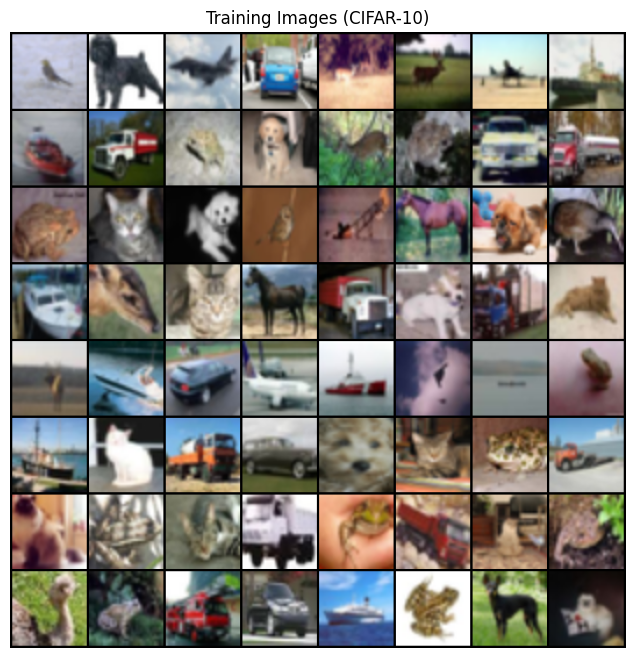

In [ ]:
# ✅ Use CIFAR-10 instead of CelebA (works immediately)
dataset = dset.CIFAR10(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))
                       ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Show sample training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images (CIFAR-10)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64],
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Z latent vector
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the generator
netG = Generator().to(device)
# Create the discriminator
netD = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Noise for generating images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Labels
real_label = 1.
fake_label = 0.

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


Starting Training Loop...
[0/25][0/391] Loss_D: 1.6995 Loss_G: 3.1490 D(x): 0.5540 D(G(z)): 0.5702/0.0652
[0/25][50/391] Loss_D: 0.1312 Loss_G: 8.3585 D(x): 0.9611 D(G(z)): 0.0781/0.0003
[0/25][100/391] Loss_D: 0.0468 Loss_G: 8.3772 D(x): 0.9770 D(G(z)): 0.0202/0.0003
[0/25][150/391] Loss_D: 0.0240 Loss_G: 8.6738 D(x): 0.9939 D(G(z)): 0.0176/0.0002
[0/25][200/391] Loss_D: 0.0119 Loss_G: 8.4029 D(x): 0.9963 D(G(z)): 0.0081/0.0002
[0/25][250/391] Loss_D: 0.0038 Loss_G: 8.5369 D(x): 0.9976 D(G(z)): 0.0013/0.0002
[0/25][300/391] Loss_D: 0.0073 Loss_G: 8.0444 D(x): 0.9979 D(G(z)): 0.0052/0.0003
[0/25][350/391] Loss_D: 0.0056 Loss_G: 7.9478 D(x): 0.9988 D(G(z)): 0.0044/0.0004
[1/25][0/391] Loss_D: 0.0069 Loss_G: 7.8820 D(x): 0.9976 D(G(z)): 0.0045/0.0004
[1/25][50/391] Loss_D: 0.0041 Loss_G: 8.1314 D(x): 0.9977 D(G(z)): 0.0017/0.0003
[1/25][100/391] Loss_D: 0.0149 Loss_G: 5.6273 D(x): 0.9942 D(G(z)): 0.0089/0.0039
[1/25][150/391] Loss_D: 0.1171 Loss_G: 6.3746 D(x): 0.9473 D(G(z)): 0.0481/0.0

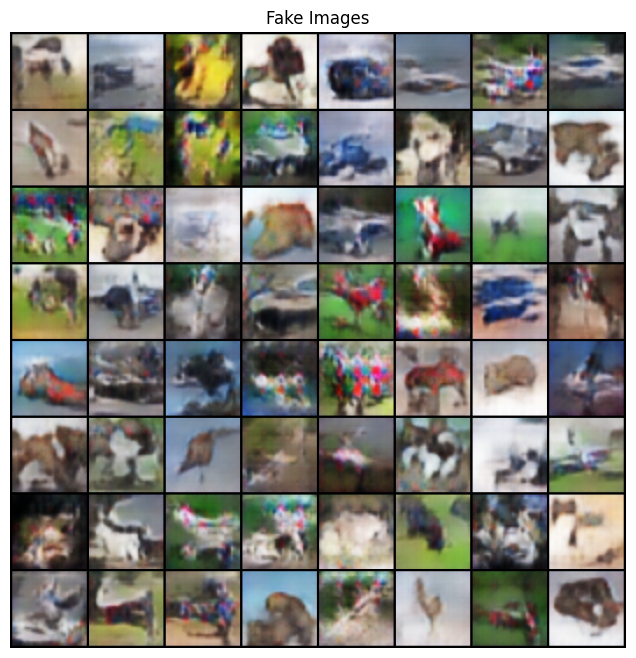

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()


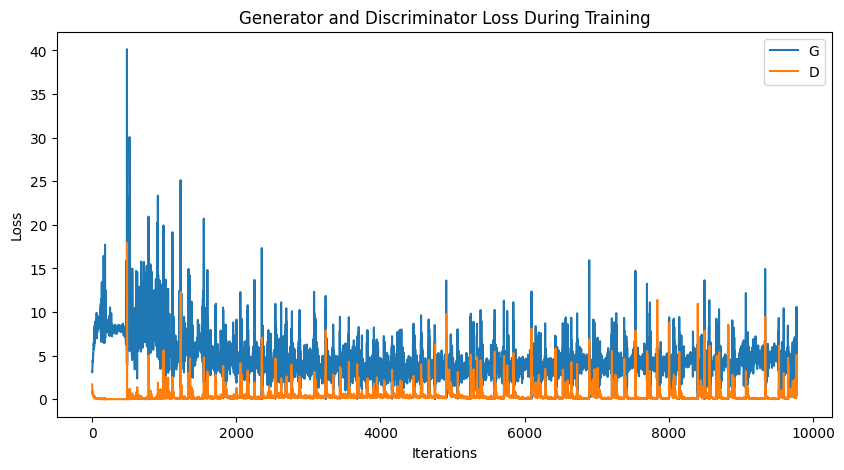

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
